In [200]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [201]:
torch.__version__

'2.0.1'

# Workflow

## Data preparing and loading

In [202]:
# Create a dataset with linear regressing (linear function)

a = 1.4  # Intercept (bias) of X
b = 0.6  # Slope (weight) of X

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)  # Dataset
y = b*X + a  # Linear function that model will try to predict

X[:10], y[:10]

# Objective: build a model to predict the value of y for each X
# Note 1: unsqueeze was used to make the print prettier

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[1.4000],
         [1.4120],
         [1.4240],
         [1.4360],
         [1.4480],
         [1.4600],
         [1.4720],
         [1.4840],
         [1.4960],
         [1.5080]]))

In [203]:
# Train/Test splitting

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

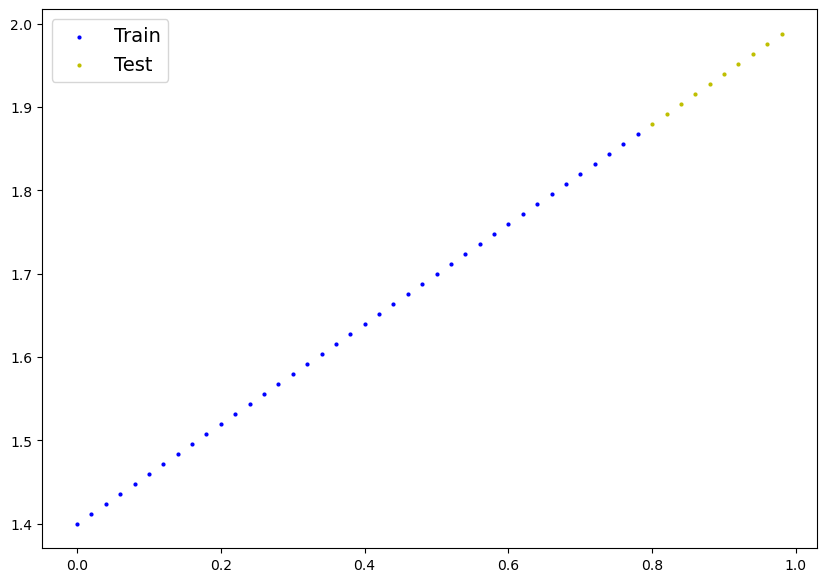

In [204]:
# Visualize the data

# Function to plot data and (if there are) predictions
def plot_data(train_data, train_labels, test_data, test_labels, predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(X_train, y_train, c='b', s=4, label='Train')
    plt.scatter(X_test, y_test, c='y', s=4, label='Test')
    
    if predictions is not None:
        plt.scatter(X_test, predictions, c='r', s=4, label='Predictions')
    
    plt.legend(prop={"size": 14})

plot_data(X_train, y_train, X_test, y_test)

## Building a model

In [205]:
# Build a linear regression model

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()  # This class inherits (super()) from the nn.Module class
        self.weights = nn.Parameter(torch.randn(1,  # Start with random values
                                                requires_grad=True,  # Values may be updated by gradient descent
                                                dtype=torch.float32))  # PyTorch main data type
        self.bias = nn.Parameter(torch.randn(1,  # Start with random values
                                             requires_grad=True,  # Values may be updated by gradient descent
                                             dtype=torch.float32))  # PyTorch main data type
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x is input
        return self.weights * x + self.bias  # Forward function (linear)

In [206]:
torch.manual_seed(42)

# Initialize an instance of the model
model0 = LinearRegressionModel()

# List the parameters
print(f"{list(model0.parameters())}\n")

# List named parameters
print(model0.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


In [207]:
# Make predictions
with torch.inference_mode():  # Disables gradient tracking, making predictions faster and more memory efficient
    y_preds = model0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

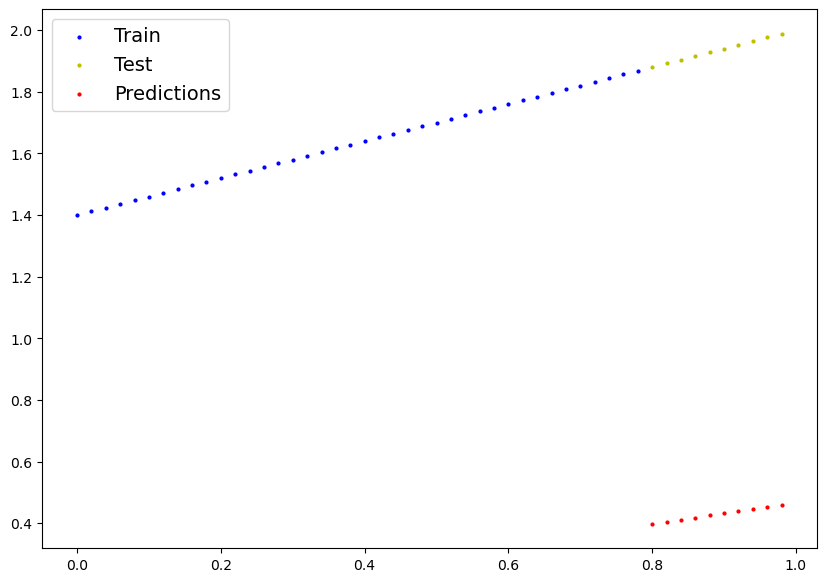

In [208]:
plot_data(X_train, y_train, X_test, y_test, y_preds)

## Training and testing the model

In [209]:
# Loss function: Determines how wrong a prediction is (lower = better)
# Optimizer: Adjusts parameters according to the loss function's values

lossfn = nn.L1Loss()  # Define a MAE (Mean Absolute Error) loss function
optimizer = torch.optim.SGD(params=model0.parameters(),  # Params: model's parameters
                            lr=0.01)  # Learning rate: magnitude of the value adjustments (per decimal case)
lossfn, optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [210]:
# Training loop
torch.manual_seed(42)

# Loops through the data
epochs = 250

# Tracking data
epoch_count = []
loss_values = []
test_loss_values = []

# 1. Setting up the loops
for epoch in range(epochs):
    model0.train()  # Train mode: activates gradient requirements (tracking) across all parameters
    
    # 2. Forward pass (propagation)
    y_pred = model0(X_train)
    
    # 3. Calculate loss
    loss = lossfn(y_pred, y_train)
    
    # 4. Optimizer zero grad
    optimizer.zero_grad()  # Resets the gradients of the previous iteration to a new tensor of 0s
    
    # 5. Backpropagation on the loss (compute the gradients)
    loss.backward()
    
    # 6. Perform a step of optimization
    optimizer.step()
    
    model0.eval()  # Evaluation mode: disables settings not needed for testing/evaluation
    with torch.inference_mode():  # Turn off gradient tracking
        # 2. Forward pass
        test_pred = model0(X_test)
        
        # 3. Compute loss
        test_loss = lossfn(y_test, test_pred)
        
        # Store tracking data
        epoch_count.append(epoch)
        test_loss_values.append(test_loss)
        loss_values.append(loss)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model0.state_dict())

Epoch: 0 | Loss: 1.3738813400268555 | Test loss: 1.492065191268921
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 1.2586712837219238 | Test loss: 1.3573553562164307
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 1.1434614658355713 | Test loss: 1.2226454019546509
OrderedDict([('weights', tensor([0.4186])), ('bias', tensor([0.3388]))])
Epoch: 30 | Loss: 1.0282515287399292 | Test loss: 1.087935447692871
OrderedDict([('weights', tensor([0.4576])), ('bias', tensor([0.4388]))])
Epoch: 40 | Loss: 0.9130415916442871 | Test loss: 0.9532256126403809
OrderedDict([('weights', tensor([0.4966])), ('bias', tensor([0.5388]))])
Epoch: 50 | Loss: 0.7978317737579346 | Test loss: 0.8185158967971802
OrderedDict([('weights', tensor([0.5356])), ('bias', tensor([0.6388]))])
Epoch: 60 | Loss: 0.6826218962669373 | Test loss: 0.6838060617446899
OrderedDict([('weights', tensor([0.5746])), ('bias', tensor([0.7388]))])
Epoch: 70

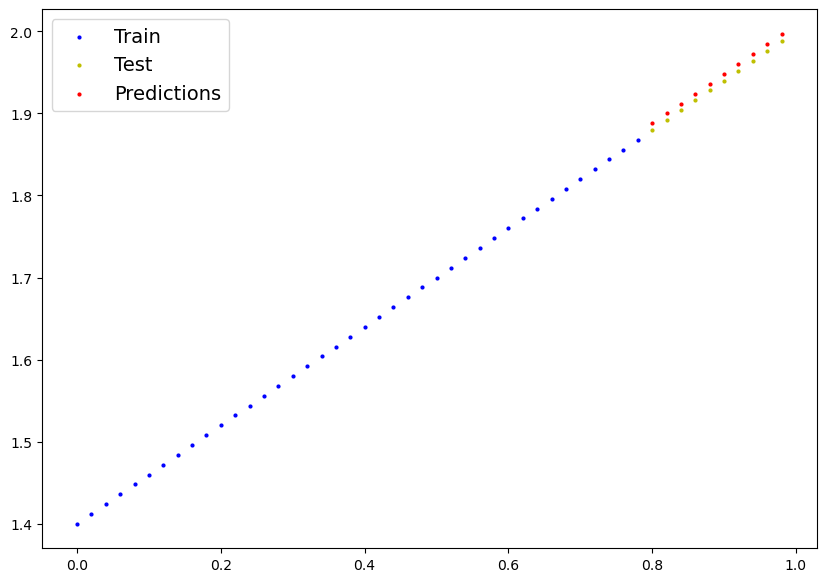

In [211]:
with torch.inference_mode():  # Disables gradient tracking, making predictions faster and more memory efficient
    y_preds_now = model0(X_test)
plot_data(X_train, y_train, X_test, y_test, y_preds_now)

In [212]:
# Arranging and plotting the model's progress

def plot_predictions(epoch_count, loss_values, test_loss_values):
    loss_values = torch.tensor(loss_values).numpy()
    test_loss_values = torch.tensor(test_loss_values).numpy()

    plt.plot(epoch_count, loss_values, label='Loss')
    plt.plot(epoch_count, test_loss_values, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and testing loss')
    plt.legend();

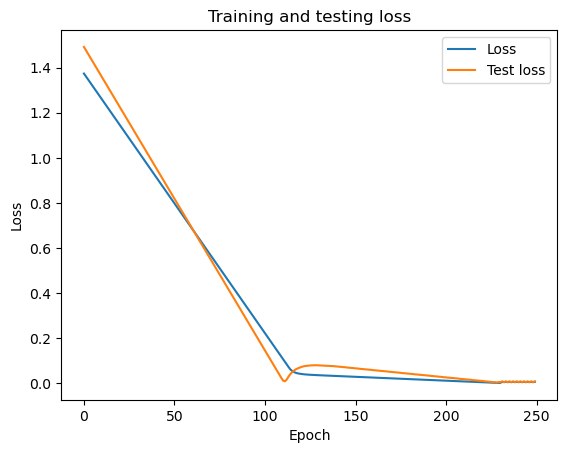

In [213]:
plot_predictions(epoch_count, loss_values, test_loss_values)

## Saving and loading a model

In [214]:
# Saving a model
# torch.save() - save a PyTorch object (model)
# torch.load() - load a PyTorch object (model)

from pathlib import Path

# 1. Creating model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Creating model's file name and path
MODEL_NAME = "01-LinearRegressionModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\01-LinearRegressionModel.pth


In [215]:
# Loading a model
# torch.nn.Module.load_state_dict() - load a model's saved state (all the training)

loaded_model0 = LinearRegressionModel()
loaded_model0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [216]:
# Testing to see if original and loaded are equal

loaded_model0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model0(X_test)

print(loaded_model_preds == y_preds_now)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


# Putting it all together

## Preparing data

In [217]:
# Quadratic regression (y = a*x**2 + b*x + c)
# Generate data

a = 1.2
b = 0.8
c = 0.5

start = -4
end = 4
step = 0.05

X = torch.arange(-4., 4., 0.05).unsqueeze(dim=1)  # IMPORTANT: without this, matrix multiplication will give an error
y = a*X**2 + b*X + c

In [218]:
# Divide data

split = int(len(X) * 0.8)

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(128, 128, 32, 32)

In [219]:
# Visualize data

def plot_data(X_train, y_train, X_test, y_test, y_pred=None):
    plt.figure(figsize=[10, 7])
    plt.scatter(X_train, y_train, c='b', s=4, label='Train')
    plt.scatter(X_test, y_test, c='y', s=4, label='Test')
    if (y_pred is not None):
        plt.scatter(X_test, y_pred, c='r', s=4, label='Prediction')
    plt.legend();

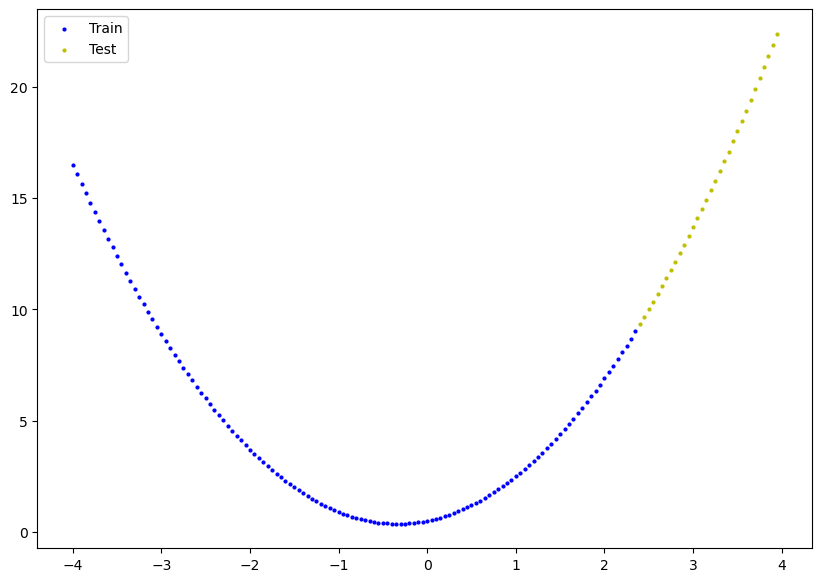

In [220]:
plot_data(X_train, y_train, X_test, y_test)

## Building the model

In [221]:
torch.manual_seed(42)

# Defining the model

class QuadraticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight2 = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float32))
        self.weight1 = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float32))
        
    def forward(self, X):
        return self.weight2*X**2 + self.weight1*X + self.bias

In [222]:
# Testing code above

model1 = QuadraticRegressionModel()
model1

QuadraticRegressionModel()

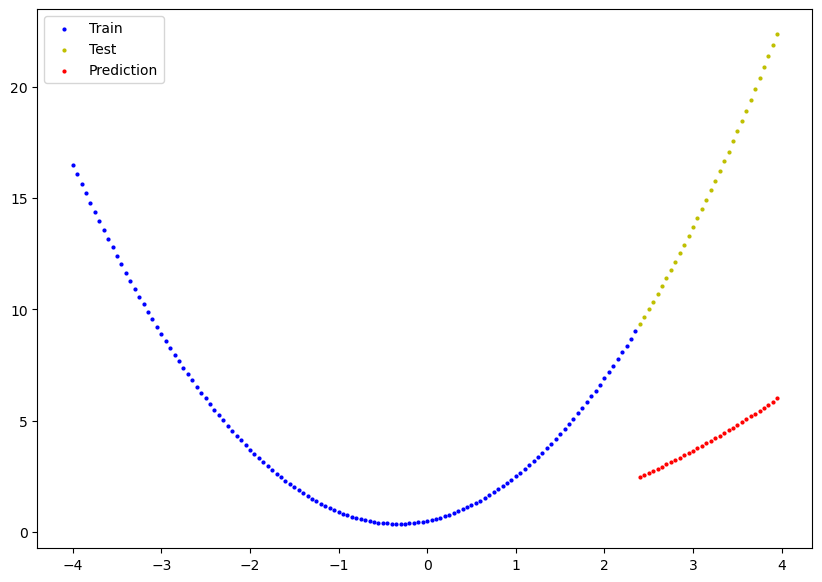

In [223]:
with torch.inference_mode():
    y_pred = model1(X_test)

plot_data(X_train, y_train, X_test, y_test, y_pred)

## Training and testing the model

In [224]:
# Loss function: MAE (Mean Absolute Error)
# Optimizer: SGD (Stochastic Gradient Descent)

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.001)

loss_fn, optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.001
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [225]:
# Defining the training function

epoch_count = []
loss_values = []
test_loss_values = []

def train_model(epochs):
    for epoch in range(1, epochs+1):
        model1.train()

        # Training procedure
        train_pred = model1(X_train)
        loss = loss_fn(train_pred, y_train)
        model1.zero_grad()
        loss.backward()
        optimizer.step()

        model1.eval()

        # Testing and storing procedure
        with torch.inference_mode():
            test_pred = model1(X_test)
            test_loss = loss_fn(test_pred, y_test)

            epoch_count.append(epoch)
            loss_values.append(loss)
            test_loss_values.append(test_loss)
    
        # if (epoch % 10 == 0):
            # print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

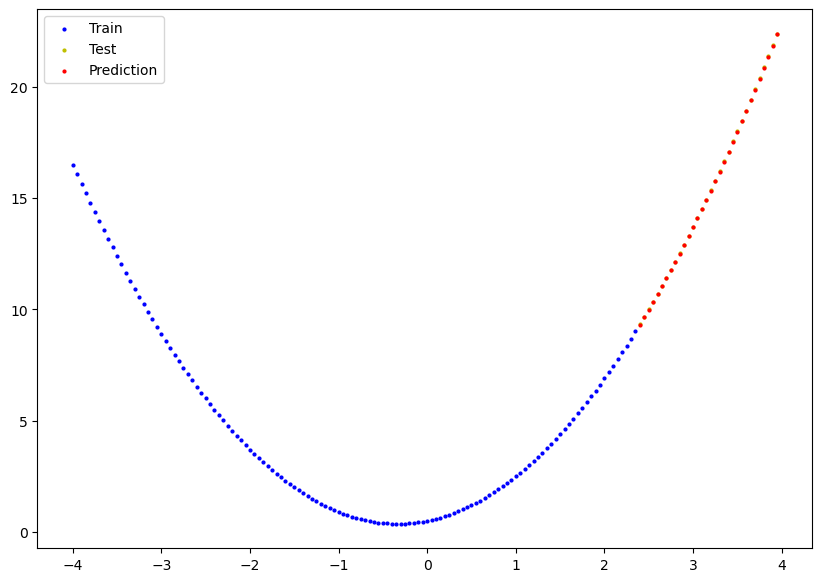

In [226]:
# Initiate training (1090 epochs was found to be an optimal number)

train_model(1090)

with torch.inference_mode():
    y_pred_now = model1(X_test)
plot_data(X_train, y_train, X_test, y_test, y_pred_now)


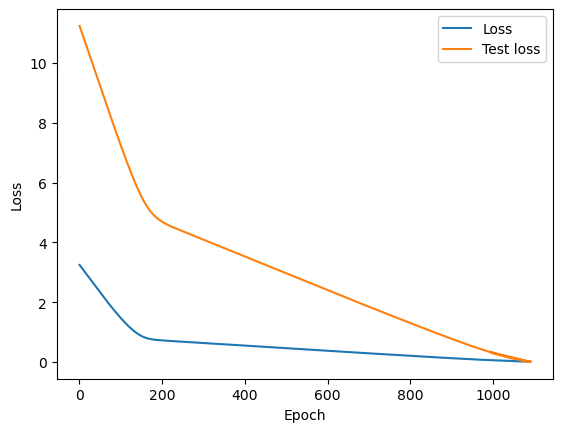

In [227]:
# Model training progress

def plot_losses(epoch_count, loss_values, test_loss_values):
    loss_values = torch.tensor(loss_values).squeeze().numpy()
    test_loss_values = torch.tensor(test_loss_values).squeeze().numpy()

    plt.plot(epoch_count, loss_values, label='Loss')
    plt.plot(epoch_count, test_loss_values, label='Test loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend();

plot_losses(epoch_count, loss_values, test_loss_values)

## Saving and loading the model

In [228]:
# Saving model

from pathlib import Path

PATH = Path("models")
PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01-QuadraticRegressionModel.pth"
SAVE_MODEL_PATH = PATH / MODEL_NAME

torch.save(model1, f=SAVE_MODEL_PATH)

In [229]:
# Loading model

loaded_model1 = torch.load(f=SAVE_MODEL_PATH)
loaded_model1.state_dict()

with torch.inference_mode():
    loaded_model1_preds = loaded_model1(X_test)

loaded_model1_preds == y_pred_now

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Linear Tranformation Model

## Data preparation

In [230]:
# For simplicity purposes, a linear function is going to be chosen. Non-linear functions require multiple layers

# Function parameters
weight = 2.1
bias = 0.3

# Data creation
start = -3
end = 3
step = 0.1

# Function
X = torch.arange(start, end, step).unsqueeze(dim=1)  # IMPORTANT: without this, matrix multiplication will give an error
y = weight*X + bias

In [231]:
# Splitting data

split = int(len(X) * 0.8)
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(48, 48, 12, 12)

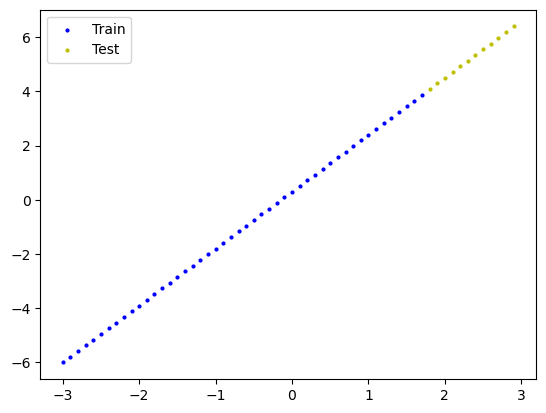

In [232]:
# Visualize data

def plot_data(X_train, y_train, X_test, y_test, y_pred=None):
    plt.figure()
    plt.scatter(X_train, y_train, s=4, c='b', label='Train')
    plt.scatter(X_test, y_test, s=4, c='y', label='Test')
    if (y_pred is not None):
        plt.scatter(X_test, y_pred, s=4, c='r', label='Prediction')
    plt.legend();

plot_data(X_train, y_train, X_test, y_test)

## Building the model

In [233]:
# Defining the model
torch.manual_seed(42)

class LinearTranformationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,   # x variable
                                      out_features=1)  # y variable
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(X)

In [234]:
# Creating a model

model2 = LinearTranformationModel()
model2, model2.state_dict()

(LinearTranformationModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

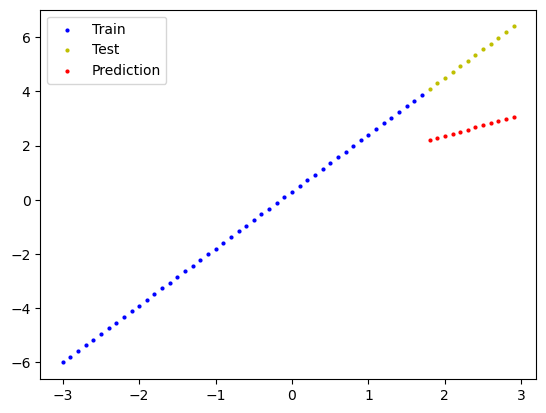

In [235]:
# Initial model prediction

with torch.inference_mode():
    y_pred = model2(X_test)
    
plot_data(X_train, y_train, X_test, y_test, y_pred)

## Training the model

In [236]:
# Loss and optimizer

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model2.parameters(),
                            lr=0.01)

loss_fn, optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [237]:
# Defining model training

epoch_count = []
loss_values = []
test_loss_values = []

def train_model(epochs):
    for epoch in range(1, epochs+1):
        model2.train()

        model2.zero_grad()
        y_pred = model2.forward(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        model2.eval()

        with torch.inference_mode():
            test_pred = model2(X_test)
            test_loss = loss_fn(test_pred, y_test)
            epoch_count.append(epoch)
            loss_values.append(loss)
            test_loss_values.append(test_loss)
        
        if (epoch % 10 == 0):
            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

In [238]:
# Train the model

epochs = 120  # Determined to be an optimal number for this seed
train_model(epochs)

Epoch: 10 | Loss: 1.7480039596557617 | Test loss: 2.3573477268218994
Epoch: 20 | Loss: 1.5717869997024536 | Test loss: 2.1104109287261963
Epoch: 30 | Loss: 1.395569920539856 | Test loss: 1.863473892211914
Epoch: 40 | Loss: 1.2193529605865479 | Test loss: 1.6165369749069214
Epoch: 50 | Loss: 1.0431360006332397 | Test loss: 1.36959969997406
Epoch: 60 | Loss: 0.8669189810752869 | Test loss: 1.1226625442504883
Epoch: 70 | Loss: 0.690701961517334 | Test loss: 0.8757256865501404
Epoch: 80 | Loss: 0.5144850611686707 | Test loss: 0.6287882924079895
Epoch: 90 | Loss: 0.3390186131000519 | Test loss: 0.38819530606269836
Epoch: 100 | Loss: 0.1645512729883194 | Test loss: 0.154338076710701
Epoch: 110 | Loss: 0.0017407011473551393 | Test loss: 0.008626461029052734
Epoch: 120 | Loss: 0.004411403555423021 | Test loss: 0.01950128935277462


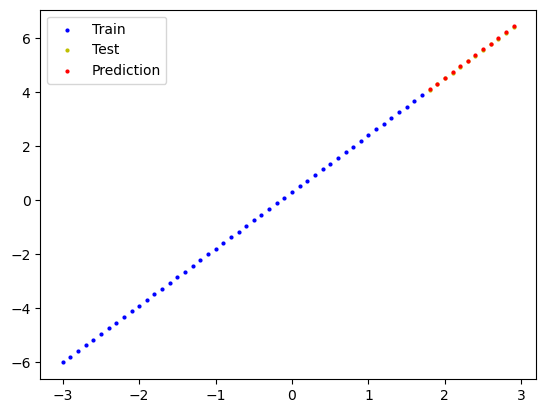

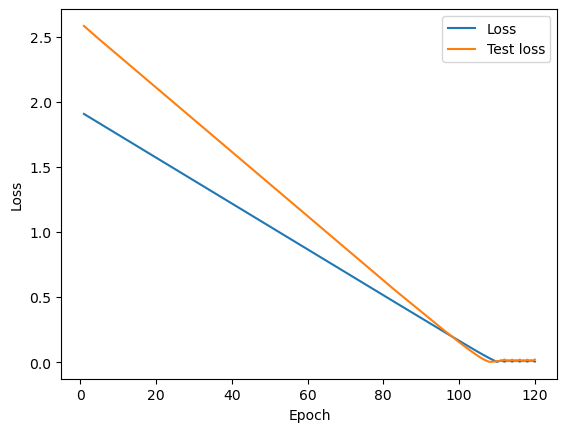

In [239]:
# Plotting results

def plot_losses(epoch_count, loss_values, test_loss_values):
    loss_values = torch.Tensor(loss_values).numpy()
    test_loss_values = torch.Tensor(test_loss_values).numpy()
    plt.figure()
    plt.plot(epoch_count, loss_values, label='Loss')
    plt.plot(epoch_count, test_loss_values, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend();

with torch.inference_mode():
    y_pred = model2(X_test)
    
plot_data(X_train, y_train, X_test, y_test, y_pred)
plot_losses(epoch_count, loss_values, test_loss_values)

## Saving and loading the model

In [240]:
# Creating saving path

from pathlib import Path

PATH = Path("models")
PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01-LinearTransformationModel.pth"
SAVE_MODEL_PATH = PATH / MODEL_NAME
SAVE_MODEL_PATH

WindowsPath('models/01-LinearTransformationModel.pth')

In [241]:
# Saving the model

torch.save(model2.state_dict(), SAVE_MODEL_PATH)

In [242]:
# Loading the model

loaded_model2 = LinearTranformationModel()
loaded_model2.load_state_dict(torch.load(SAVE_MODEL_PATH))

loaded_model2.eval()
with torch.inference_mode():
    loaded_pred = loaded_model2(X_test)

y_pred == loaded_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Exercises

## 0. Import libraries and create device agnostic code

In [243]:
# Libraries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [244]:
# Device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Create a straight line dataset using the linear regression formula (weight * X + bias)

In [245]:
# weight = 0.3, bias = 0.9, split = 80/20, dataset size = 100

weight = 0.3
bias = 0.9

start = 0
end = 1
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

X[:10], y[:10], X.shape

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.9000],
         [0.9030],
         [0.9060],
         [0.9090],
         [0.9120],
         [0.9150],
         [0.9180],
         [0.9210],
         [0.9240],
         [0.9270]]),
 torch.Size([100, 1]))

In [246]:
# Splitting the data

split = int(0.8*len(X))

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

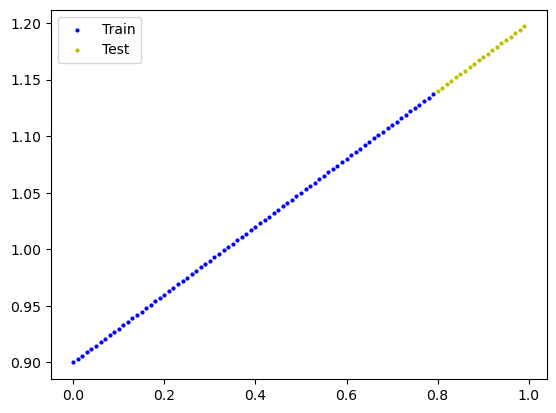

In [247]:
def plot_data(X_train, y_train, X_test, y_test, y_pred=None):
    plt.figure()
    plt.scatter(X_train, y_train, s=4, c='b', label='Train')
    plt.scatter(X_test, y_test, s=4, c='y', label='Test')
    if (y_pred is not None):
        plt.scatter(X_test, y_pred, s=4, c='r', label='Pred')
    plt.legend();

plot_data(X_train, y_train, X_test, y_test)

## 2. Build a PyTorch model by subclassing nn.Module

In [248]:
# nn.linear will be used
torch.manual_seed(42)

class ExerciseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
        
    def forward(self, X):
        return self.linear_layer(X)

In [249]:
# Creating model instance

modelex = ExerciseModel()
modelex, modelex.state_dict()

(ExerciseModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

## 3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively

In [250]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=modelex.parameters(),
                            lr=0.01)
loss_fn, optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [251]:
# Defining training cycle

torch.manual_seed(42)
epoch_count=[]
loss_values=[]
test_loss_values=[]

def train_model(epochs):
    for epoch in range(1, epochs+1):
        modelex.train()

        modelex.zero_grad()
        y_pred = modelex.forward(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        if (epoch % 20 == 0):
            modelex.eval()

            with torch.inference_mode():
                test_pred = modelex(X_test)
                test_loss = loss_fn(test_pred, y_test)

                epoch_count.append(epoch)
                loss_values.append(loss)
                test_loss_values.append(test_loss)

            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


In [252]:
# Train the model

train_model(300)

Epoch: 20 | Loss: 0.08270234614610672 | Test loss: 0.22185663878917694
Epoch: 40 | Loss: 0.07244014739990234 | Test loss: 0.17603714764118195
Epoch: 60 | Loss: 0.06542257964611053 | Test loss: 0.15386894345283508
Epoch: 80 | Loss: 0.0585714690387249 | Test loss: 0.13754181563854218
Epoch: 100 | Loss: 0.05171937867999077 | Test loss: 0.12155871093273163
Epoch: 120 | Loss: 0.04486827552318573 | Test loss: 0.10523159801959991
Epoch: 140 | Loss: 0.03801713138818741 | Test loss: 0.08890429884195328
Epoch: 160 | Loss: 0.03116495907306671 | Test loss: 0.07292068749666214
Epoch: 180 | Loss: 0.024313753470778465 | Test loss: 0.056593120098114014
Epoch: 200 | Loss: 0.017462557181715965 | Test loss: 0.040265560150146484
Epoch: 220 | Loss: 0.010610383935272694 | Test loss: 0.02428193762898445
Epoch: 240 | Loss: 0.0037596062757074833 | Test loss: 0.007956618443131447
Epoch: 260 | Loss: 0.003681749105453491 | Test loss: 0.006471020169556141
Epoch: 280 | Loss: 0.003681749105453491 | Test loss: 0.0064

OrderedDict([('linear_layer.weight', tensor([[0.3028]])),
             ('linear_layer.bias', tensor([0.8910]))])

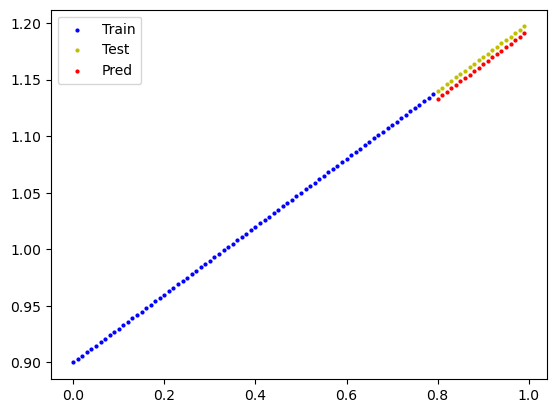

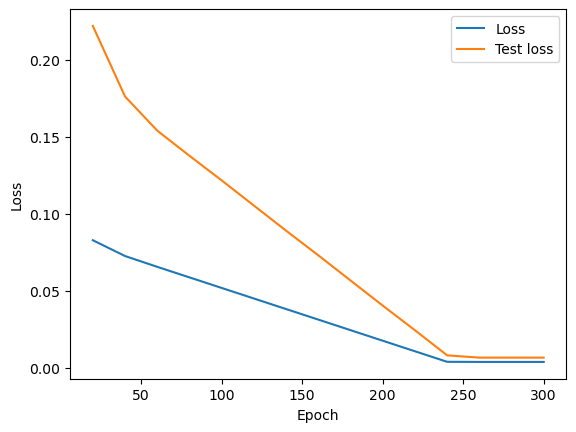

In [253]:
# Visualizing the losses and predictions

def plot_losses(loss_values, test_loss_values):
    loss_values = torch.tensor(loss_values).numpy()
    test_loss_values = torch.tensor(test_loss_values).numpy()

    plt.figure()
    plt.plot(epoch_count, loss_values, label='Loss')
    plt.plot(epoch_count, test_loss_values, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend();

with torch.inference_mode():
    y_pred = modelex(X_test)

plot_data(X_train, y_train, X_test, y_test, y_pred)
plot_losses(loss_values, test_loss_values)
modelex.state_dict()

## 4. Saving and loading the model

In [254]:
# Create saving path

from pathlib import Path

PATH = Path("models")
MODEL_NAME = "01-ExerciseModel.pth"
SAVING_MODEL_PATH = PATH / MODEL_NAME
SAVING_MODEL_PATH

WindowsPath('models/01-ExerciseModel.pth')

In [255]:
# Save model

torch.save(modelex.state_dict(), SAVING_MODEL_PATH)

In [256]:
# Load model

loaded_modelex = ExerciseModel()
loaded_modelex.load_state_dict(torch.load(SAVING_MODEL_PATH))

<All keys matched successfully>

In [257]:
# Testing loaded model

loaded_modelex.eval()

with torch.inference_mode():
    loaded_modelex_pred = loaded_modelex(X_test)

loaded_modelex_pred == y_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])